# **1. 모델 설계**

In [1]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm.notebook import tqdm

device = "mps:0" if torch.backends.mps.is_available() else "cpu"
device = torch.device(device)
print(device)

mps:0


데이터 다운: https://www.kaggle.com/datasets/dansbecker/cityscapes-image-pairs

In [2]:
import os

root_path = '/Users/jaehyunoh/Desktop/학교/학회/YBIGTA/2024-2DS/Week02_Segmentation/cityscapes_data'

data_dir = root_path
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
train_fns = os.listdir(train_dir)
val_fns = os.listdir(val_dir)

print(len(train_fns), len(val_fns))

2975 500


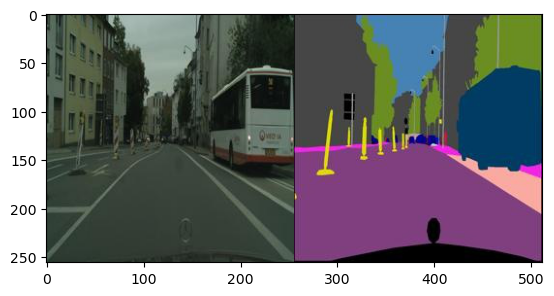

In [3]:
import matplotlib.pyplot as plt
from PIL import Image

sample_image_fp = os.path.join(train_dir, train_fns[0])
sample_image = Image.open(sample_image_fp).convert("RGB")

plt.imshow(sample_image)
plt.show()

In [4]:
import numpy as np
num_items = 1000
color_array = np.random.choice(range(256), 3*num_items).reshape(-1, 3)
print(color_array.shape)

(1000, 3)


In [5]:
from sklearn.cluster import KMeans
num_classes = 10
label_model = KMeans(n_clusters = num_classes)
label_model.fit(color_array)

/Users/jaehyunoh/miniforge3/envs/venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=10)

In [6]:
def split_image(image) :
   image = np.array(image)
   cityscape, label = image[:, :256, :], image[:, 256:, :]
   return cityscape, label

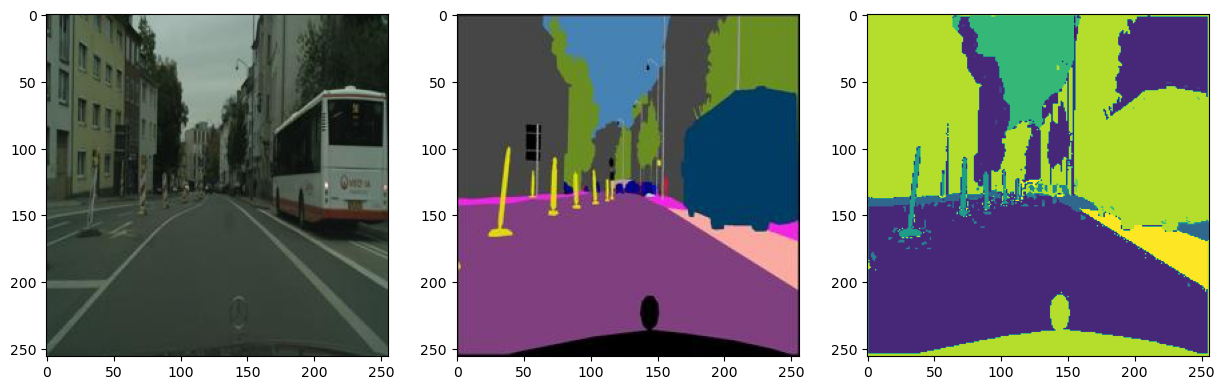

In [7]:
cityscape, label = split_image(sample_image)

label_class = label_model.predict(label.reshape(-1, 3)).reshape(256, 256)
fig, axes = plt.subplots(1, 3, figsize = (15, 5))
axes[0].imshow(cityscape)
axes[1].imshow(label)
axes[2].imshow(label_class)

plt.show()

In [8]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms

class CityscapeDataset(Dataset):

  def __init__(self, image_dir, label_model):
    self.image_dir = image_dir
    self.image_fns = os.listdir(image_dir)
    self.label_model = label_model

  def __len__(self) :
    return len(self.image_fns)

  def __getitem__(self, index) :
    image_fn = self.image_fns[index]
    image_fp = os.path.join(self.image_dir, image_fn)
    image = Image.open(image_fp)
    image = np.array(image)
    cityscape, label = self.split_image(image)
    label_class = self.label_model.predict(label.reshape(-1, 3)).reshape(256, 256)
    label_class = torch.Tensor(label_class).long()
    cityscape = self.transform(cityscape)
    return cityscape, label_class

  def split_image(self, image) :
    image = np.array(image)
    cityscape, label = image[ : , :256, : ], image[ : , 256: , : ]
    return cityscape, label

  def transform(self, image) :
    transform_ops = transforms.Compose([
      			transforms.ToTensor(),
                        transforms.Normalize(mean = (0.485, 0.56, 0.406), std = (0.229, 0.224, 0.225))
    ])
    return transform_ops(image)

dataset = CityscapeDataset(train_dir, label_model)
print(len(dataset))

cityscape, label_class = dataset[0]
print(cityscape.shape)
print(label_class.shape)

2975
torch.Size([3, 256, 256])
torch.Size([256, 256])


In [9]:
import torch
import torch.nn as nn

class UNet(nn.Module):

    def __init__(self, num_classes):
        super(UNet, self).__init__()
        # 인코더 (Contracting Path)
        self.enc1 = self.conv_block(3, 64)   # (입력 채널, 출력 채널)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)
        
        # 중간층 (Bottleneck)
        self.bottleneck = self.conv_block(512, 1024)

        # 디코더 (Expanding Path)
        self.dec4 = self.conv_block(1024 + 512, 512)  # 업샘플 후 채널 수를 결합
        self.dec3 = self.conv_block(512 + 256, 256)
        self.dec2 = self.conv_block(256 + 128, 128)
        self.dec1 = self.conv_block(128 + 64, 64)

        # 최종 출력층
        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)  # 마지막 Conv 층 (1x1 커널)

    def conv_block(self, in_channels, out_channels):
        # Conv -> BatchNorm -> LeakyReLU -> Conv -> BatchNorm -> LeakyReLU
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.1),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.1)
        )

    def forward(self, X):
        # 인코딩 경로 (인코더)
        enc1_out = self.enc1(X)
        enc2_out = self.enc2(F.max_pool2d(enc1_out, 2))
        enc3_out = self.enc3(F.max_pool2d(enc2_out, 2))
        enc4_out = self.enc4(F.max_pool2d(enc3_out, 2))
        
        # 중간층
        bottleneck_out = self.bottleneck(F.max_pool2d(enc4_out, 2))

        # 디코딩 경로 (디코더) - 업샘플링 후 스킵 연결
        dec4_out = self.dec4(torch.cat([F.interpolate(bottleneck_out, scale_factor=2, mode='bilinear', align_corners=True), enc4_out], dim=1))
        dec3_out = self.dec3(torch.cat([F.interpolate(dec4_out, scale_factor=2, mode='bilinear', align_corners=True), enc3_out], dim=1))
        dec2_out = self.dec2(torch.cat([F.interpolate(dec3_out, scale_factor=2, mode='bilinear', align_corners=True), enc2_out], dim=1))
        dec1_out = self.dec1(torch.cat([F.interpolate(dec2_out, scale_factor=2, mode='bilinear', align_corners=True), enc1_out], dim=1))

        # 최종 출력
        output_out = self.final_conv(dec1_out)

        return output_out

In [10]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

model = UNet(num_classes=num_classes)
data_loader = DataLoader(dataset, batch_size = 4)
print(len(dataset), len(data_loader))

X, Y = next(iter(data_loader))
print(X.shape)
print(Y.shape)

2975 744
torch.Size([4, 3, 256, 256])
torch.Size([4, 256, 256])


In [11]:
Y_pred = model(X)
print(Y_pred.shape)

torch.Size([4, 10, 256, 256])


# **2. 모델 학습**

In [12]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.optim as optim
from tqdm import tqdm

device = torch.device("mps:0" if torch.backends.mps.is_available() else "cpu")

## 하이퍼파라미터 자율설정

batch_size = 4

epochs = 5
lr = 0.01

dataset = CityscapeDataset(train_dir, label_model)
data_loader = DataLoader(dataset, batch_size = batch_size)

model = UNet(num_classes = num_classes).to(device)

# 손실함수 정의
criterion = nn.CrossEntropyLoss()
# Optimizer 정의
optimizer = optim.Adam(model.parameters(), lr = lr)


step_losses = []
epoch_losses = []

for epoch in tqdm(range(epochs)) :
  epoch_loss = 0

  for X, Y in tqdm(data_loader, total = len(data_loader), leave = False) :
    X, Y = X.to(device), Y.to(device)
    optimizer.zero_grad()
    Y_pred = model(X)
    loss = criterion(Y_pred, Y)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
    step_losses.append(loss.item())
  epoch_losses.append(epoch_loss/len(data_loader))

100%|██████████| 5/5 [26:16<00:00, 315.25s/it]


In [13]:
print(len(epoch_losses))
print(epoch_losses)

5
[0.8236691866430544, 0.636739453000407, 0.5579490086404226, 0.5133393856706798, 0.480868700250823]


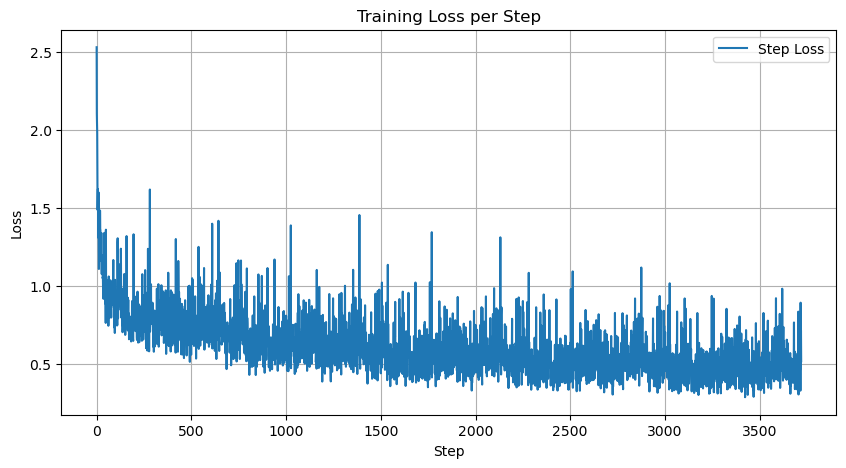

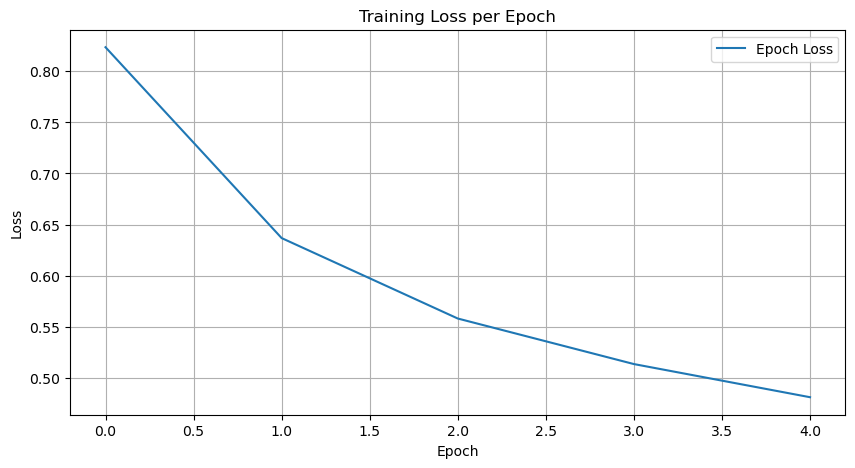

In [15]:
# Step losses plot
plt.figure(figsize=(10, 5))
plt.plot(step_losses, label="Step Loss")
plt.title("Training Loss per Step")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# Epoch losses plot
plt.figure(figsize=(10, 5))
plt.plot(epoch_losses, label="Epoch Loss")
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()
plt.show()

In [16]:
model_name = "UNet.pth"
torch.save(model.state_dict(), root_path + model_name)

# **3. 모델 평가**

In [17]:
model_path = root_path + model_name
model_ = UNet(num_classes = num_classes).to(device)
model_.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [18]:
test_batch_size = 8
dataset = CityscapeDataset(val_dir, label_model)
data_loader = DataLoader(dataset, batch_size = test_batch_size)

X,Y = next(iter(data_loader))
X,Y = X.to(device), Y.to(device)
Y_pred = model_(X)
print(Y_pred.shape)
Y_pred = torch.argmax(Y_pred, dim=1)
print(Y_pred.shape)

torch.Size([8, 10, 256, 256])
torch.Size([8, 256, 256])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


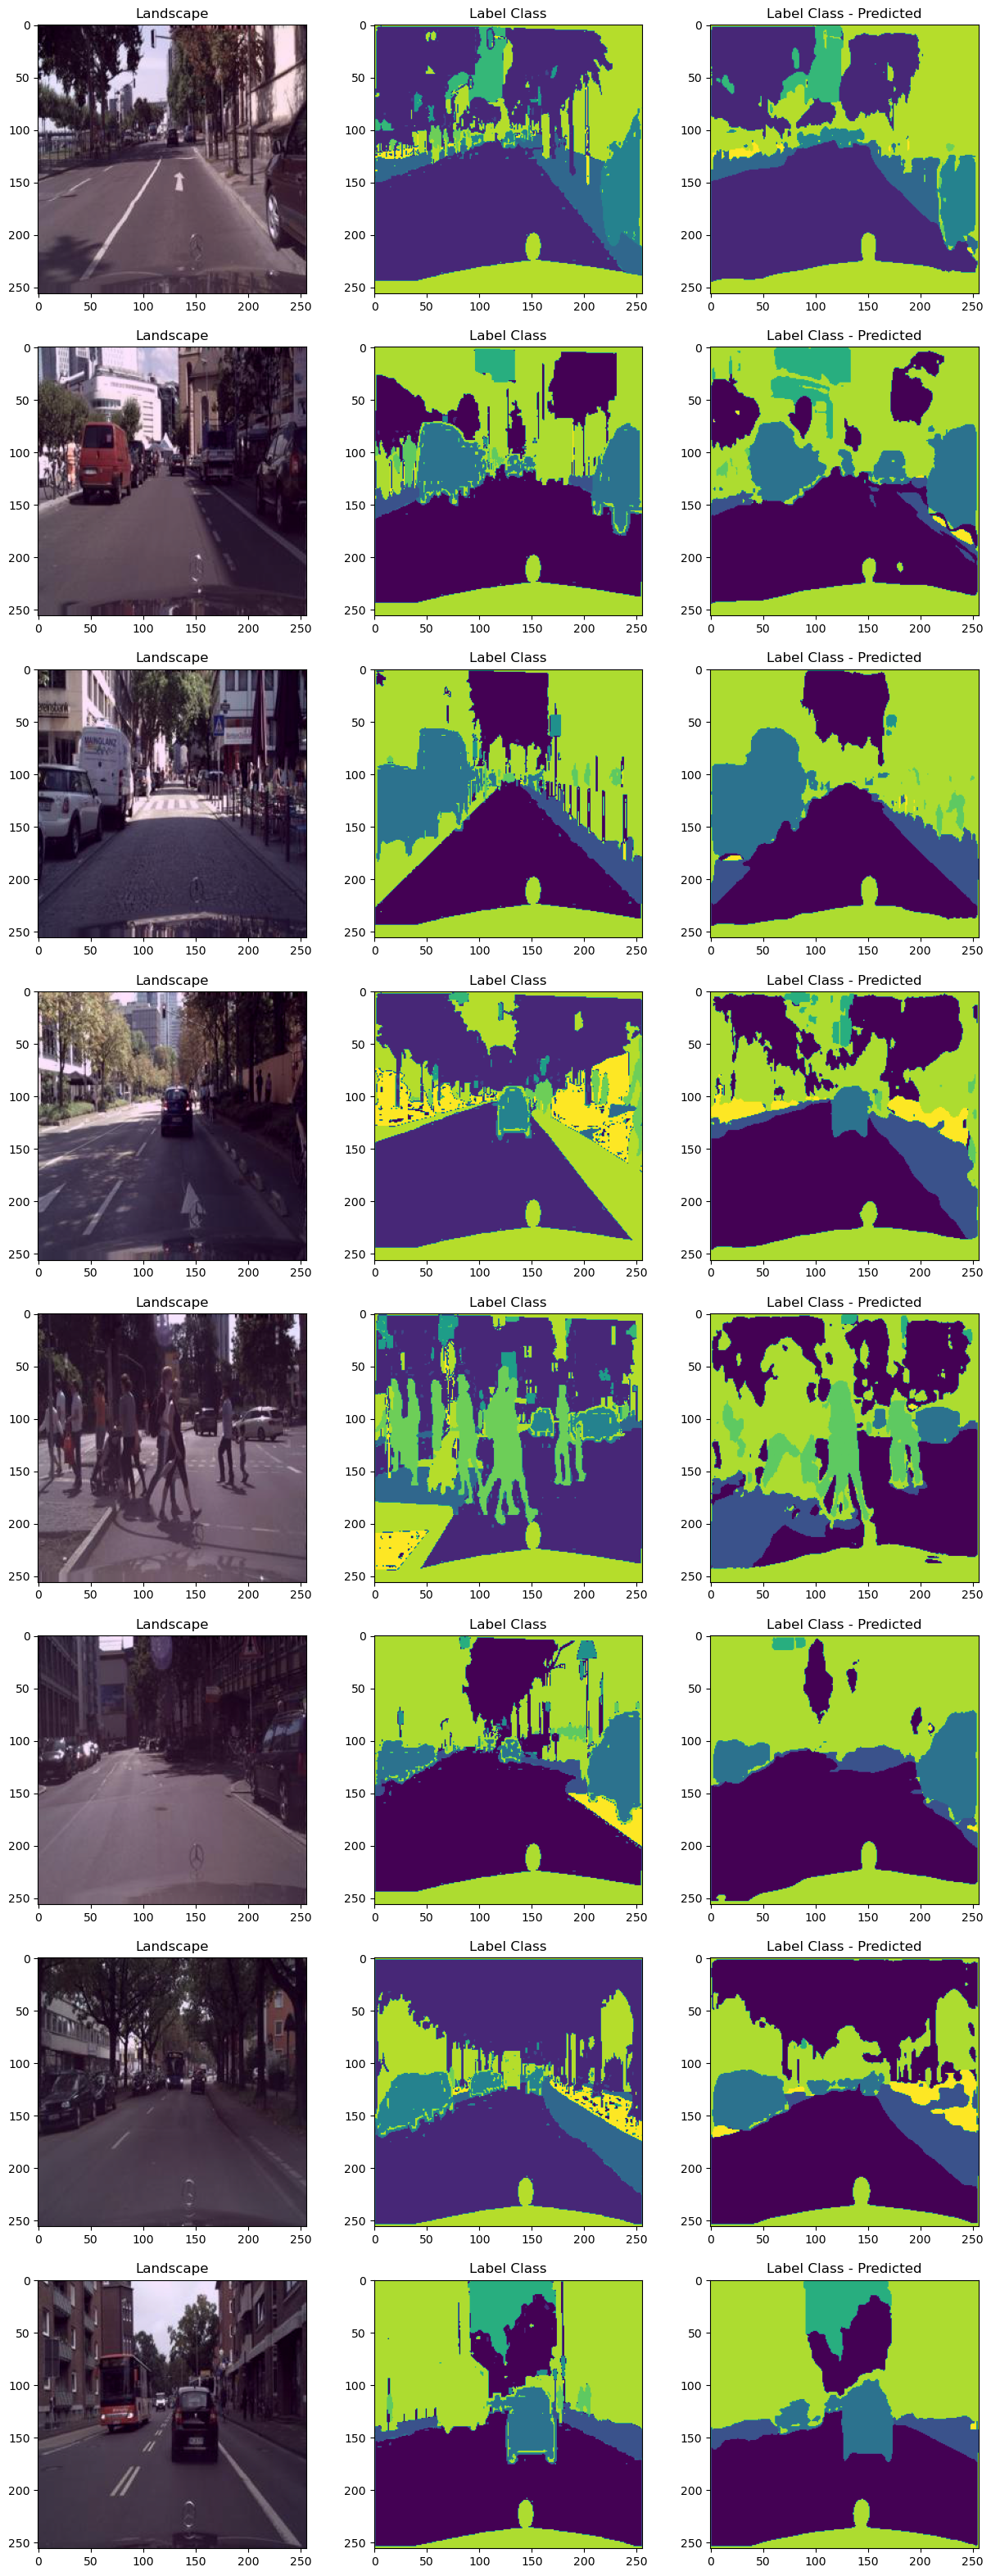

In [19]:
inverse_transform = transforms.Compose([
    transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
])
fig, axes = plt.subplots(test_batch_size, 3, figsize=(3*5, test_batch_size*5))

iou_scores = []

for i in range(test_batch_size):

    landscape = inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()

    # IOU score
    intersection = np.logical_and(label_class, label_class_predicted)
    union = np.logical_or(label_class, label_class_predicted)
    iou_score = np.sum(intersection) / np.sum(union)
    iou_scores.append(iou_score)

    axes[i, 0].imshow(landscape)
    axes[i, 0].set_title("Landscape")
    axes[i, 1].imshow(label_class)
    axes[i, 1].set_title("Label Class")
    axes[i, 2].imshow(label_class_predicted)
    axes[i, 2].set_title("Label Class - Predicted")

plt.show()

# **4. IoU Score**

In [24]:
##TODO

print(iou_scores)

[0.9996795654296875, 1.0, 1.0, 0.9948577880859375, 0.9991607666015625, 1.0, 0.9974365234375, 1.0]
